<a href="https://colab.research.google.com/github/aditeyabaral/haiku/blob/main/notebook/haiku_Sequence_Labelling_biLSTM_CRF_with_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
! pip install keras-self-attention
! pip install keras-crf

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import json
import numpy as np
import pandas as pd
import re
import string

import matplotlib.pyplot as plt

import keras
from keras_self_attention import SeqSelfAttention
from keras_crf import CRF
from keras.layers import Lambda
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [ ]:
import json
import numpy as np
import pandas as pd
import re
import string
from google.colab import files
from gensim.models import FastText
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
# from keras_self_attention import SeqSelfAttention

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open ("/content/drive/MyDrive/Colab Notebooks/NLP/dataset.json") as d:
  dfd_json = json.load(d)

# Preprocessing

In [ ]:
poems = list()
haikus = list()
indices = list()

MIN_THRESHOLD_HAIKU = 5
MAX_THRESHOLD_POEM = 120

for dataset in dfd_json:
  for poem in dataset:
    for grammar_index in poem:
      if grammar_index == "poem":
        continue
      else:
        haiku_data = poem[grammar_index]
        for haiku, index in list(haiku_data.items()):
          if len(index) >= MIN_THRESHOLD_HAIKU and len(poem["poem"].split()) <= MAX_THRESHOLD_POEM:
            poems.append(poem["poem"])
            haikus.append(haiku)
            indices.append(index)



df = pd.DataFrame()
df["poem"] = poems
df["haiku"] = haikus
df["indices"] = indices
df = df.drop_duplicates(subset=["poem"])
df = df.reset_index(drop=True)

## Training fastText

In [ ]:
X_words = list(map(word_tokenize, df["poem"].values))
y_words = list(map(word_tokenize, df["haiku"].values))

In [ ]:
ft_model = FastText(min_count=1)
ft_model.build_vocab(sentences=X_words)
ft_model.train(sentences=X_words, total_examples=ft_model.corpus_count, epochs=5)

In [ ]:
word2embedding = {word:ft_model.wv.get_vector(word) for word in list(ft_model.wv.vocab)}

## Creating Embedding Matrices

In [ ]:
X_text = df["poem"].values
tokenizer_X = Tokenizer()
tokenizer_X.fit_on_texts(list(X_text))
vocab_size_X = len(tokenizer_X.word_index) + 1 

In [ ]:
embedding_matrix_X = np.zeros((vocab_size_X, 100))
for word, i in tokenizer_X.word_index.items():
	embedding_vector = word2embedding.get(word)
	if embedding_vector is not None:
		embedding_matrix_X[i] = embedding_vector

## Dataset Generation

In [ ]:
df.head()

,poem,haiku,indices
0,Did the CIA tell the FBI that it knows the wor...,cia fbi the biggest weapon,"[2, 5, 9, 24, 25]"
1,"Dark clouds gathered overhead,\nExpelling bull...",clouds overhead bullets of the valley,"[1, 3, 5, 6, 10, 11]"
2,A vigilante lacking of heroic qualities that\n...,lacking qualities that damn criminals,"[2, 5, 6, 11, 12]"
3,"(A Diamante Poem)\nBrain\nHeavenly, hellish\nF...",diamante poem the sybaritic pathetic,"[1, 2, 10, 18, 19]"
4,Can I break tradition?\nWill it be okay?\nI'll...,ill speaks a worst condition,"[8, 31, 37, 47, 48]"


In [ ]:
df.shape

(16903, 3)

In [ ]:
df = df.sample(1000)
df.head()

,poem,haiku,indices
15841,"I will not tend. Or water,\npull, or yank,\nI ...",watch dirt a wide room,"[27, 68, 70, 71, 73]"
5354,Like the Ocean kissed The Sky\nAt the most bea...,ocean sky the beautiful place as the ocean,"[2, 5, 7, 9, 10, 100, 111, 112]"
2522,I believe in yesterdays with fine tunes\nWhere...,yesterdays fine tunes through all afternoons,"[3, 5, 6, 11, 28, 31]"
10199,"I was enriched, not casting after marvels,\r\r...",got random a sweet note,"[31, 50, 54, 70, 77]"
13302,The Fathers put their trust in the end of the ...,put gnostics some wealth grumbles,"[2, 16, 28, 30, 55]"


In [ ]:
def clean(s):
    s = s.translate(str.maketrans('', '', string.punctuation)).strip().lower()
    return s

In [ ]:
poems = list(df["poem"])
tags = list(df["indices"])
poem_no = []
word = []
tag = []

for i in range(len(poems)):
    poem = poems[i].split()

    count_poem = [i+1] * len(poem)
    poem_no.extend(count_poem)

    word.extend(poem)

    count_tag = [0] * len(poem)
    for j in tags[i]:
        count_tag[j] = 1
    tag.extend(count_tag)

word = list(map(clean, word))

In [ ]:
dataset = {"poem_no" : poem_no, "word" : word, "tag" : tag}
df = pd.DataFrame(dataset)
df = df[df["word"] != ""]

In [ ]:
df.head()

,poem_no,word,tag
0,1,i,0
1,1,will,0
2,1,not,0
3,1,tend,0
4,1,or,0


In [ ]:
df.shape

(83463, 3)

# Model Building

In [ ]:
words = list(set(df["word"].values))
words.append("ENDPAD")

In [ ]:
n_words = len(words); n_words

13533

In [ ]:
tags = list(set(df["tag"].values))

In [ ]:
n_tags = len(tags); n_tags

2

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("poem_no").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        # try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        # except:
        #     return None

In [ ]:
getter = SentenceGetter(df)

In [ ]:
sent = getter.get_next()

In [ ]:
print(sent)

[('i', 0), ('will', 0), ('not', 0), ('tend', 0), ('or', 0), ('water', 0), ('pull', 0), ('or', 0), ('yank', 0), ('i', 0), ('will', 0), ('not', 0), ('till', 0), ('uproot', 0), ('fill', 0), ('up', 0), ('or', 0), ('spray', 0), ('the', 0), ('rain', 0), ('comes', 0), ('or', 0), ('not', 0), ('plants', 0), ('sunfed', 0), ('moonhopped', 0), ('dirtstuck', 0), ('watch', 1), ('as', 0), ('flocks', 0), ('of', 0), ('wild', 0), ('phlox', 0), ('appear', 0), ('disappear', 0), ('my', 0), ('lazy', 0), ('garbagey', 0), ('magic', 0), ('makes', 0), ('this', 0), ('nothing', 0), ('happen', 0), ('i', 0), ('love', 0), ('the', 0), ('tattered', 0), ('camisole', 0), ('of', 0), ('nothing', 0), ('the', 0), ('world', 0), ('runs', 0), ('its', 0), ('underbrush', 0), ('course', 0), ('fed', 0), ('by', 0), ('the', 0), ('nothing', 0), ('i', 0), ('give', 0), ('it', 0), ('wars', 0), ('are', 0), ('fought', 0), ('blood', 0), ('turns', 0), ('dirt', 1), ('is', 0), ('a', 1), ('wide', 1), ('unruly', 0), ('room', 1)]


In [ ]:
sentences = getter.sentences # list(list(("word", tag)))

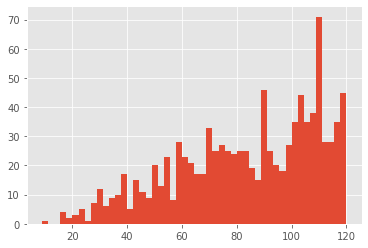

In [ ]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
max_len = 120
word2idx = {w: i for i, w in enumerate(words)}  # {word:enum}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [ ]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [ ]:
X.shape

(1000, 120)

In [ ]:
X[1]

array([11432,  1756,   464,   138,  1756,  1880,  5383,  1756, 11118,
         165,  8318,  8981,  1756,  6958,  2753,  3850, 10478, 10676,
        3219, 11680, 11990,  2138,  4099,  9672,  7179, 13097,  4572,
        2753,   522,  6223,  8129, 13279,  3774,  4910,   509,  2694,
        7353, 12008,  8318,  7232,  3350,  7232, 10497, 12775,  6393,
       11202,  8981,  1756,  6958,  2694,  4270,  5529,  3219, 12648,
        5344,  4910,  4333,  1756,   464,  9320,  1880, 10316,  6087,
         138,  3414,  1756,  6958, 12817,  9320, 12817,  4782, 10534,
         522,  6607,  5670,   276, 11990,  2191, 11432,  1756,   464,
         138,  1756,  1880,  2753,   522,  6607,  6393, 11432,  8727,
       10849, 12830, 11801,  1015,  4043,  1924, 12817,  9320, 12817,
       10534,  2755,  4901, 12080,  9320,  5529, 13232,  9672,  7498,
        7278,  5383,  4333,  1756,   464,   138,  1756,  1880, 13532,
       13532, 13532, 13532], dtype=int32)

In [ ]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [ ]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx[0])

In [ ]:
y[1]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [ ]:
y[1]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(y), test_size=0.1)

In [ ]:
max_len = 120
latent_dim=128

In [ ]:
model = Sequential(
    [
     Input(shape=(max_len, )),
     Embedding(vocab_size_X, 100, weights=[embedding_matrix_X], trainable=False),
     Dropout(0.2),
     Bidirectional(LSTM(latent_dim, return_sequences=True)),
     Dropout(0.2),
     Bidirectional(LSTM(latent_dim, return_sequences=True)),
     SeqSelfAttention(),
     TimeDistributed(Dense(2, activation='softmax')),
     CRF(n_tags)
    ]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(
    X_train, y_train, 
    batch_size=128, 
    epochs=5, 
    validation_data=([X_test, y_test])
    )

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


8/8 [==============================] - 31s 3s/step - loss: 0.4956 - accuracy: 0.0474 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
8/8 [==============================] - 20s 2s/step - loss: 0.4073 - accuracy: 0.0471 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
8/8 [==============================] - 20s 2s/step - loss: 0.3942 - accuracy: 0.0475 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/5
8/8 [==============================] - 20s 2s/step - loss: 0.3810 - accuracy: 0.0475 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/5
8/8 [==============================] - 20s 2s/step - loss: 0.3679 - accuracy: 0.0472 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
hist

,loss,accuracy,val_loss,val_accuracy
0,0.453584,0.047306,0.0,0.0
1,0.405520,0.047306,0.0,0.0
2,0.392048,0.047306,0.0,0.0
3,0.378909,0.047306,0.0,0.0
4,0.366151,0.047306,0.0,0.0


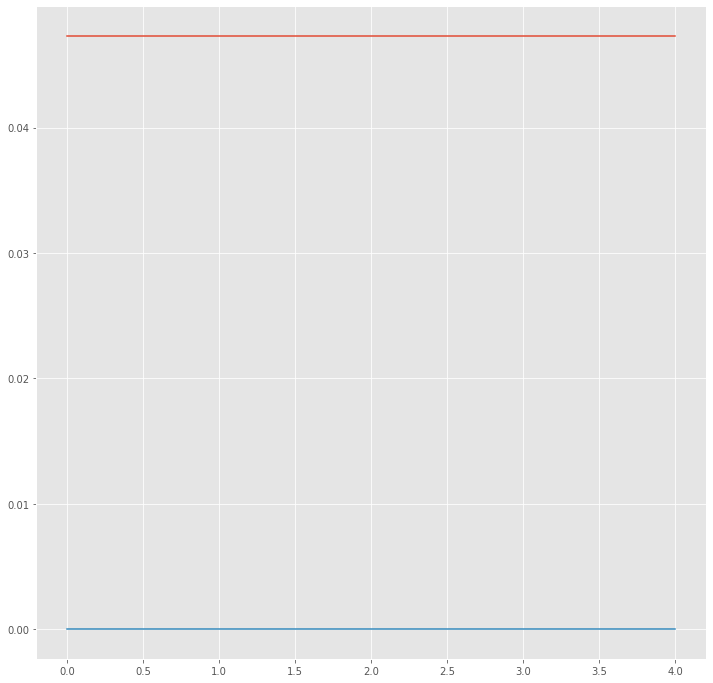

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

# Testing

In [ ]:
def remove_end(sentence):
    remove_list = ['ENDPAD']
    word_list = sentence.split()
    return ' '.join([i for i in word_list if i not in remove_list])

In [ ]:
for i in range(20):

    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)

    sent = []
    true = []
    pred = []

    for w in X_test[i]:
        sent.append(words[w])



    true_label = []
    for j in range(len(y_test[i])):
        ind = y_test[i][j][-1]
        true_label.append(int(ind))

    for y in range(len(true_label)):
        if true_label[y] == 1:
            true.append(sent[y])



    pred_label = p[0]
    for k in range(len(pred_label)):
        if pred_label[k] == 1:
            pred.append(sent[k])

    sent = remove_end(" ".join(sent))
    true = remove_end(" ".join(true))
    pred = remove_end(" ".join(pred))

    print("Sentence = ", sent)
    print()
    print("True = ", true)
    print()
    print("Predicted = ", pred)

    print("\n\n\n")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


Sentence =  so the sun is shining blindingly but i can sort of see it’s like looking at mandela’s moral beauty the dying leaves are sizzling on the trees in a shirtsleeves summer breeze but daylight saving is over and gaveling the courtroom to order with a fourleaf clover is over and it’s altogether november and the pellegrino bubbles rise to the surface and dismember

True =  sun leaves summer is to the surface

Predicted =  so the sun is shining blindingly but i can sort of see it’s like looking at mandela’s moral beauty the dying leaves are sizzling on the trees in a shirtsleeves summer breeze but daylight saving is over and gaveling the courtroom to order with a fourleaf clover is over and it’s altogether november and the pellegrino bubbles rise to the surface and dismember




Sentence =  hes still young— thirty but looks younger— or does he in the eyes and cheeks tonight turning in the mirror he saw his mother— puffy angry bewildered many nights now when he stares there he gets a

# References

1) https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/

2) https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/


# Save Model

In [ ]:
# model.save("seq-lab.h5")

In [ ]:
# from google.colab import files
# files.download("seq-lab.h5")

# Load and test the model

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('seq-lab.h5')

In [ ]:
# # from random import randint
# # i = randint(1,len(X_te))

# for i in range(100):

#     p = model.predict(np.array([X_test[i]]))
#     p = np.argmax(p, axis=-1)

#     sent = []
#     true = []
#     pred = []

#     for w in X_test[i]:
#         sent.append(words[w])



#     true_label = []
#     for j in range(len(y_test[i])):
#         ind = y_test[i][j][-1]
#         true_label.append(int(ind))

#     for y in range(len(true_label)):
#         if true_label[y] == 1:
#             true.append(sent[y])



#     pred_label = p[0]
#     for k in range(len(pred_label)):
#         if pred_label[k] == 1:
#             pred.append(sent[k])



#     print("Sentence = ", sent)
#     print("True = ", true)
#     print("Predicted = ", pred)

#     print("\n\n\n")